In [1]:
# %matplotlib notebook
import numpy as np
import os
from matplotlib import image, pyplot as plt
import json
from celluloid import Camera
from collections import defaultdict

_ZI = np.complex(0, 1)

In [2]:
from pywave.scattering.mass_loading import MassLoadingESW # Properties of a segment of string
from pywave.scattering.helmholtz_1d_boundary import Helmholtz1DBoundary # Scattering by a change in string properties
from pywave.scattering.medium_boundary import MediumBoundary
from pywave.scattering.multiple_scatterer import MultipleScatterer # Multiple scattering module
from pywave.utils.lib import vector_min, vector_max

In [3]:
class RandomField:
    
    def __init__(self, num_floes=500, mean_d=50, mean_h=1, 
                 sic=.9, rel_width_d=.1, rel_width_h=.1):
        
        self.num_floes = num_floes
        self.mean_h = mean_h
        self.mean_d = mean_d
        self.sic = sic
        self.mean_sep = self.mean_d * (1-self.sic) * self.num_floes / (self.num_floes - 1)
        self.rel_width_d = rel_width_d
        self.rel_width_h = rel_width_h
        
        self.set_ice_properties()
        self.set_edges()

    @staticmethod
    def get_random_field(mean, num_floes, rel_width=.1, cut_off=.5):
        rand = np.random.normal(
            loc=mean, scale=rel_width*mean, size=(num_floes,))
        rand = vector_max(rand, cut_off*mean)
        rand = vector_min(rand, (1 + cut_off)*mean)
        rand *= mean/np.mean(rand)
        return rand
        
    def set_ice_properties(self):
        self.thicks = np.zeros((2*self.num_floes+1,))
        self.thicks[1:-1:2] = self.get_random_field(
            self.mean_h, self.num_floes, rel_width=self.rel_width_h)
        self.widths = self.get_random_field(
            self.mean_d, self.num_floes, rel_width=self.rel_width_d)
        self.seps = self.get_random_field(
            self.mean_sep, self.num_floes - 1, rel_width=self.rel_width_d)
        
    def set_edges(self):
        self.edges = np.zeros((2*self.num_floes,))
        for i in range(self.num_floes):
            self.edges[2*i+1] = self.edges[2*i] + self.widths[i]
            if i == self.num_floes - 1: break
            self.edges[2*i+2] = self.edges[2*i+1] + self.seps[i]

    def get_multiple_scatterer(self, **kwargs):
        
        # initialise and solve the individual scattering problems
        x = [-np.inf, *self.edges, np.inf]
        print(x)
        scatterers = []
        media = [MassLoadingESW(
            thickness=self.thicks[0], xlim=x[:2], **kwargs), []]
        num_edges = len(self.edges)
        for i in range(num_edges):
            print(f"Solving edge {i} (out of {num_edges})")
            print()
            media[1] = MassLoadingESW(
                thickness=self.thicks[i+1], xlim=x[i+1:i+3], **kwargs)
            scatterers += [Helmholtz1DBoundary(
                *media, position=self.edges[i])]
            scatterers[-1].solve()
            media[0] = media[1]
            
        return MultipleScatterer(scatterers)

In [4]:
fld = RandomField(num_floes=3)

In [5]:
ms = fld.get_multiple_scatterer()

[-inf, 0.0, 51.380562639867726, 58.12490352623365, 107.50031404383844, 115.75597315747251, 165.0, inf]
Solving edge 0 (out of 6)

Solving edge 1 (out of 6)

Solving edge 2 (out of 6)

Solving edge 3 (out of 6)

Solving edge 4 (out of 6)

Solving edge 5 (out of 6)



In [6]:
ms.solve()

In [7]:
e_info = ms.get_energy_info()

[1.00334334-8.26043764e-06j] [0.00234822+0.0013335j]
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[0.80425237+0.59429681j] [0.0052899+0.00288966j]
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[0.75474446+0.66112024j] [0.00266144-0.00103599j]
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[0.23756895+0.9713661j] [0.00365824+0.00186721j]
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
[0.13833325+0.99400401j] [0.00163503-0.00320335j]
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [8]:
e_info

{'x': array([  0.        ,  51.38056264,  58.12490353, 107.50031404,
        115.75597316, 165.        ]),
 'cg': array([16.6338964 , 16.97131762, 16.63288322, 16.97131762, 16.61029587]),
 'ep': array([[5.06407223e-05],
        [5.03043260e-05],
        [5.06417940e-05],
        [5.03033469e-05],
        [5.06649786e-05]]),
 'em': array([[3.66831911e-10],
        [1.82769647e-09],
        [4.10303559e-10],
        [8.48586062e-10],
        [6.50666914e-10]])}

In [9]:
#net flux should be constant
e_info['cg'] * (e_info['em'] - e_info['ep']).flatten()

array([-0.00084235, -0.0008537 , -0.00084231, -0.0008537 , -0.00084155])

In [10]:
# ms.test_energy()

In [11]:
# ms.test_energy_flux()

In [12]:
ms.test_boundary_conditions()


Test boundary conditions at boundary 0:
displacement = (0.7771336067023489+0.447797417989076j) = (0.7771336067023487+0.44779741798907624j)?
stress = (0.003661766439602879+0.009999725186456504j) = (0.0036617664396028783+0.009999725186456502j)?

Test boundary conditions at boundary 1:
displacement = (0.8929179049588464+1.0917698906210325j) = (0.8929179049588465+1.0917698906210325j)?
stress = (-0.0008065443924595052+0.005880531716244979j) = (-0.0008065443924595043+0.005880531716244979j)?

Test boundary conditions at boundary 2:
displacement = (0.8816707776607953+1.1476167615015296j) = (0.8816707776607953+1.1476167615015296j)?
stress = (-0.001408947564711504+0.005120347885281962j) = (-0.001408947564711503+0.005120347885281961j)?

Test boundary conditions at boundary 3:
displacement = (0.6222705531308826+1.3015463033194101j) = (0.6222705531308825+1.3015463033194101j)?
stress = (-0.005265346752911675-0.0011597843656040996j) = (-0.005265346752911673-0.0011597843656040983j)?

Test boundary co

<AxesSubplot:title={'center':'u at t=0s'}, xlabel='x, m', ylabel='u, m'>

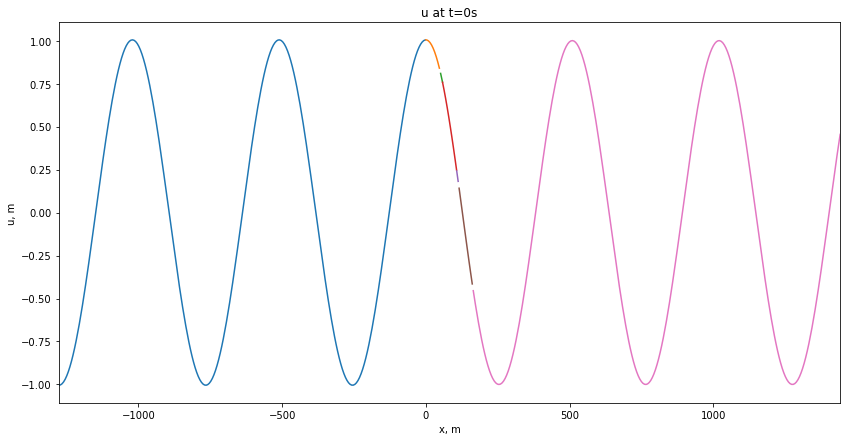

In [13]:
ms.plot_expansion()

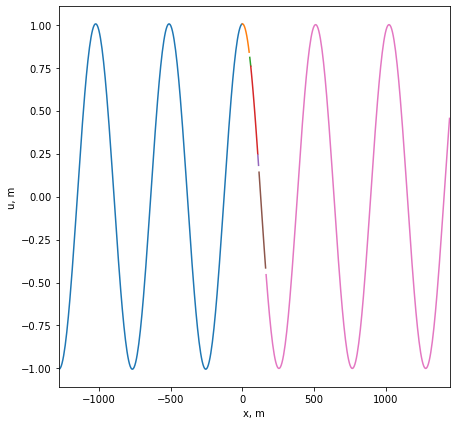

Saving figs/animation4.gif


In [14]:
ms.animate_displacement('figs/animation4.gif')

### Display animation of displacement
![SegmentLocal](figs/animation4.gif "segment")